<a href="https://colab.research.google.com/github/srpauliscu/nlp-shared-task/blob/main/semeval_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Data Format

**Data:** `arguments-training/validation/testing.tsv`
(5220 arguments)
- Argument ID
- Conclusion 
- Stance (e.g., in favor, against)
- Premise (justification for conclusion)

**Labels:** `labels-training/validation/testing.tsv` 
(20 binary value labels per argument)
- Argument ID
- Self-direction: thought
- Self-direction: action
- Stimulation
- Hedonism
- Achievement
- Power: dominance
- Power: resources
- Face
- Security: personal
- Security: societal
- Tradition
- Conformity: rules
- Conformity: interpersonal
- Humility
- Benevolence: caring
- Benevolence: dependability
- Universalism: concern
- Universalism: nature
- Universalism: tolerance
- Universalism: objectivity

**Access:** https://doi.org/10.5281/zenodo.6814563

## Setup

In [ ]:
# clear working environment
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# install
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 48.0 MB/s 
     |████████████████████████████████| 182 kB 60.8 MB/s 


In [ ]:
# imports
import pandas as pd
from transformers import AutoTokenizer
from typing import Dict, List
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load data

In [ ]:
# training arguments
train_args_df = pd.read_csv('/content/drive/MyDrive/csci5832_project/data/arguments-training.tsv', sep='\t')
# view structure
train_args_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5220 entries, 0 to 5219
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Argument ID  5220 non-null   object
 1   Conclusion   5220 non-null   object
 2   Stance       5220 non-null   object
 3   Premise      5220 non-null   object
dtypes: object(4)
memory usage: 163.2+ KB


In [ ]:
# training labels
train_labs_df = pd.read_csv('/content/drive/MyDrive/csci5832_project/data/labels-training.tsv', sep='\t')
# view structure
train_labs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5220 entries, 0 to 5219
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 5220 non-null   object
 1   Self-direction: thought     5220 non-null   int64 
 2   Self-direction: action      5220 non-null   int64 
 3   Stimulation                 5220 non-null   int64 
 4   Hedonism                    5220 non-null   int64 
 5   Achievement                 5220 non-null   int64 
 6   Power: dominance            5220 non-null   int64 
 7   Power: resources            5220 non-null   int64 
 8   Face                        5220 non-null   int64 
 9   Security: personal          5220 non-null   int64 
 10  Security: societal          5220 non-null   int64 
 11  Tradition                   5220 non-null   int64 
 12  Conformity: rules           5220 non-null   int64 
 13  Conformity: interpersonal   5220 non-null   int6

## Prep Data

In [ ]:
# convert multiple label columns to one label list column
train_labs_df['labels'] = train_labs_df.loc[:, 'Self-direction: thought':'Universalism: objectivity'].values.tolist()

In [ ]:
# label distribution for full training data
print('Self-direction: thought =', sum(train_labs_df['Self-direction: thought']))
print('Self-direction: action =', sum(train_labs_df['Self-direction: action']))
print('Stimulation =', sum(train_labs_df['Stimulation']))
print('Hedonism =', sum(train_labs_df['Hedonism']))
print('Achievement = ', sum(train_labs_df['Achievement']))
print('Power: dominance =', sum(train_labs_df['Power: dominance']))
print('Power: resources =', sum(train_labs_df['Power: resources']))
print('Face =', sum(train_labs_df['Face']))
print('Security: personal =', sum(train_labs_df['Security: personal']))
print('Security: societal =', sum(train_labs_df['Security: societal']))
print('Tradition =', sum(train_labs_df['Tradition']))
print('Conformity: rules =', sum(train_labs_df['Conformity: rules']))
print('Conformity: interpersonal =', sum(train_labs_df['Conformity: interpersonal']))
print('Humility =', sum(train_labs_df['Humility']))
print('Benevolence: caring =', sum(train_labs_df['Benevolence: caring']))
print('Benevolence: dependability =', sum(train_labs_df['Benevolence: dependability']))
print('Universalism: concern =', sum(train_labs_df['Universalism: concern']))
print('Universalism: nature =', sum(train_labs_df['Universalism: nature']))
print('Universalism: tolerance =', sum(train_labs_df['Universalism: tolerance']))
print('Universalism: objectivity =', sum(train_labs_df['Universalism: objectivity']))

print('\nTotal number of samples = ', len(train_labs_df))

Self-direction: thought = 913
Self-direction: action = 1332
Stimulation = 312
Hedonism = 202
Achievement =  1400
Power: dominance = 461
Power: resources = 566
Face = 374
Security: personal = 1961
Security: societal = 1627
Tradition = 598
Conformity: rules = 1222
Conformity: interpersonal = 217
Humility = 438
Benevolence: caring = 1500
Benevolence: dependability = 766
Universalism: concern = 1992
Universalism: nature = 358
Universalism: tolerance = 709
Universalism: objectivity = 937

Total number of samples =  5220


In [ ]:
# combine dfs to add label list to data dictionary
train_merged_df = pd.merge(train_args_df, train_labs_df, on='Argument ID')
train_merged_df = train_merged_df.drop(columns=['Self-direction: thought',
                                                'Self-direction: action',
                                                'Stimulation',
                                                'Hedonism',
                                                'Achievement',
                                                'Power: dominance',
                                                'Power: resources',
                                                'Face',
                                                'Security: personal',
                                                'Security: societal',
                                                'Tradition',
                                                'Conformity: rules',
                                                'Conformity: interpersonal',
                                                'Humility',
                                                'Benevolence: caring',
                                                'Benevolence: dependability',
                                                'Universalism: concern',
                                                'Universalism: nature',
                                                'Universalism: tolerance',
                                                'Universalism: objectivity'])

In [ ]:
# view structure
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5220 entries, 0 to 5219
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Argument ID  5220 non-null   object
 1   Conclusion   5220 non-null   object
 2   Stance       5220 non-null   object
 3   Premise      5220 non-null   object
 4   labels       5220 non-null   object
dtypes: object(5)
memory usage: 244.7+ KB


## Split

In [ ]:
# split train data into 80/20 train/val
train_data, val_data = train_test_split(train_merged_df, test_size=0.2, random_state=4)
train_data.head()

,Argument ID,Conclusion,Stance,Premise,labels
4531,A07017,Homeopathy brings more harm than good,against,homeopathy uses natural remedies that have lit...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4475,A24284,We should abandon television,against,Television is the gateway for many to news and...,"[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1031,A18184,We should abolish safe spaces,against,safe spaces are important for those who do not...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
1471,A19216,Assisted suicide should be a criminal offence,in favor of,assisted suicide is heartless and inhumane,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
4411,A22162,We should adopt atheism,against,anyone is entitled to believe in whatever they...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."


In [ ]:
# convert each row to a dictionary -> List[Dict]
train_data = train_data.to_dict(orient='records')
val_data = val_data.to_dict(orient='records')
full_data = train_merged_df.to_dict(orient='records')
# print examples
print('training example:\n', train_data[0])
print('validation example:\n', val_data[0])
print('full example:\n', full_data[0])

training example:
 {'Argument ID': 'A07017', 'Conclusion': 'Homeopathy brings more harm than good', 'Stance': 'against', 'Premise': 'homeopathy uses natural remedies that have little to no side affects on the body.', 'labels': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]}
validation example:
 {'Argument ID': 'A18174', 'Conclusion': 'The vow of celibacy should be abandoned', 'Stance': 'against', 'Premise': "the vow of celibacy should be promoted as it brings the sense of self control and purity to a person's soul.", 'labels': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]}
full example:
 {'Argument ID': 'A01001', 'Conclusion': 'Entrapment should be legalized', 'Stance': 'in favor of', 'Premise': "if entrapment can serve to more easily capture wanted criminals, then why shouldn't it be legal?", 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## Tokenize

In [ ]:
# function to load samples from HuggingFace dataset to be batched and encoded

class BatchTokenizer:
    """Tokenizes and pads a batch of input sentences."""
    """HuggingFace docs: https://huggingface.co/transformers/v3.0.2/preprocessing.html"""

    def __init__(self):
        """Initializes the tokenizer

        Args:
            pad_symbol (Optional[str], optional): The symbol for a pad. Defaults to "<P>".
        """
        self.hf_tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small")
    
    # HuggingFace tokenizer will join data with sentence separator token
    # and match batches of tokenized and encoded sentences
    def get_sep_token(self,):
        return self.hf_tokenizer.sep_token

    # call method can only take a pair of inputs, but we have three
    # conclusion batch, stance batch, and premise batch
    # so we create a hack
    #def __call__(self, con_batch: List[str], stan_batch: List[str], prem_batch: List[str]) -> List[List[str]]:

    def __call__(self, con_stan_batch: List[str], prem_batch: List[str]) -> List[List[str]]:  
        """Uses the huggingface tokenizer to tokenize and pad a batch.

        We return a dictionary of tensors per the huggingface model specification.

        Args:
            batch (List[str]): A List of sentence strings

        Returns:
            Dict: The dictionary of token specifications provided by HuggingFace
        """
        # The HF tokenizer will PAD for us, and additionally combine 
        # the two sentences deimited by the [SEP] token.
        enc = self.hf_tokenizer(
            con_stan_batch,
            prem_batch,
            #stan_batch,
            #prem_batch,
            padding=True,
            return_token_type_ids=False, # ignore with hack
            return_tensors='pt'
        )

        return enc

In [ ]:
# define tokenizer
tokenizer = BatchTokenizer()

In [ ]:
# example of use case for batch tokenizer
#token_ex = tokenizer(*[['this is the conclusion.', 'this is also a conclusion'], ['this is the stance.', 'this is also a stance'], ['this is the premise', 'this is also a premise']])
#tokenizer.hf_tokenizer.batch_decode(token_ex['input_ids'])
# HF tokenizer not working for three input sentence types

In [ ]:
# example of use case for batch tokenizer without triplet hack (only two input types acceptable)
token_ex = tokenizer(*[['this is the conclusion with more words', 'this is also a conclusion'], ['this is the premise', 'this is the second premise']])
print(token_ex)
tokenizer.hf_tokenizer.batch_decode(token_ex['input_ids'])

{'input_ids': tensor([[  101,  2023,  2003,  1996,  7091,  2007,  2062,  2616,   102,  2023,
          2003,  1996, 18458,   102],
        [  101,  2023,  2003,  2036,  1037,  7091,   102,  2023,  2003,  1996,
          2117, 18458,   102,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}


['[CLS] this is the conclusion with more words [SEP] this is the premise [SEP]',
 '[CLS] this is also a conclusion [SEP] this is the second premise [SEP] [PAD]']

In [ ]:
# example of use case for batch tokenizer with triplet hack
token_ex2 = tokenizer(*[['this is the conclusion with more words [SEP] and a stance against', 'this is also a conclusion [SEP] with another stance that is in favor of'], ['this is the premise', 'this is the second premise']])
print(token_ex2)
tokenizer.hf_tokenizer.batch_decode(token_ex2['input_ids'])

{'input_ids': tensor([[  101,  2023,  2003,  1996,  7091,  2007,  2062,  2616,   102,  1998,
          1037, 11032,  2114,   102,  2023,  2003,  1996, 18458,   102,     0,
             0,     0],
        [  101,  2023,  2003,  2036,  1037,  7091,   102,  2007,  2178, 11032,
          2008,  2003,  1999,  5684,  1997,   102,  2023,  2003,  1996,  2117,
         18458,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


['[CLS] this is the conclusion with more words [SEP] and a stance against [SEP] this is the premise [SEP] [PAD] [PAD] [PAD]',
 '[CLS] this is also a conclusion [SEP] with another stance that is in favor of [SEP] this is the second premise [SEP]']

## Batch

In [ ]:
# function to generate triple-wise inputs

def generate_triplewise_input(dataset: List[Dict]) -> (List[str], List[str], List[str], List[str], List[List[int]]):
    """
    group all argument components and corresponding labels of the datapoints
    a datapoint is now a dictionary of 
    argument id, conclusion, stance, premise, and label list
    """

    # extract each observation from dictionary; save to list
    d_vals = []
    for i in range(len(dataset)):
        d_vals.append(list(dataset[i].values()))

    # store data items in lists by three categories by id
    id_lst = []    
    conclusion_lst = []
    stance_lst = []
    premise_lst = []

    # store labels in list of lists of 20 labels
    label_lst = []

    # generate separate lists from each observation
    for i in range(len(d_vals)):
        id_lst.append(d_vals[i][0])
        conclusion_lst.append(d_vals[i][1])
        stance_lst.append(d_vals[i][2])
        premise_lst.append(d_vals[i][3])
        label_lst.append(d_vals[i][4])

    # add [SEP] token before every stance in list
    stance_lst = [' [SEP] ' + s for s in stance_lst]

    return id_lst, conclusion_lst, stance_lst, premise_lst, label_lst

In [ ]:
# apply function to generate triple-wise inputs and labels for batching

# training data
train_ids, train_conclusions, train_stances, train_premises, train_labels = generate_triplewise_input(train_data)

# validation data
val_ids, val_conclusions, val_stances, val_premises, val_labels = generate_triplewise_input(val_data)

# full data
full_ids, full_conclusions, full_stances, full_premises, full_labels = generate_triplewise_input(full_data)

In [ ]:
# temporarily combine conclusions and stances separate with [SEP]
# use hack to merge tokenized conclusion batch, stance batch, and premise batch

# training data
train_conclusions_stances = []
for i in range(len(train_conclusions)):
  train_conclusions_stances.append(train_conclusions[i] + train_stances[i])

# validation data
val_conclusions_stances = []
for i in range(len(val_conclusions)):
  val_conclusions_stances.append(val_conclusions[i] + val_stances[i])

# full data
full_conclusions_stances = []
for i in range(len(full_conclusions)):
  full_conclusions_stances.append(full_conclusions[i] + full_stances[i])

In [ ]:
# define batch size
batch_size = 128

In [ ]:
# define functions to chunk data for batches

# for train labels
def chunk(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i: i+n]

# for train features
def chunk_multi(lst1, lst2, n):
    for i in range(0, len(lst1), n):
        yield lst1[i: i+n], lst2[i: i+n]

In [ ]:
# apply function to batch input data 
# tokenize and encode simultaneously since we are using HuggingFace

# batch
train_input_batches = [b for b in chunk_multi(train_conclusions_stances, train_premises, batch_size)]
val_size = 1
full_size = 1
val_input_batches = [b for b in chunk_multi(val_conclusions_stances, val_premises, val_size)]
full_input_batches = [b for b in chunk_multi(full_conclusions_stances, full_premises, full_size)]

# tokenize + encode
train_input_batches = [tokenizer(*batch) for batch in train_input_batches]
val_input_batches = [tokenizer(*batch) for batch in val_input_batches]
full_input_batches = [tokenizer(*batch) for batch in full_input_batches]


In [ ]:
# check training data example
print(train_input_batches[0])
encoded_tst = tokenizer.hf_tokenizer.batch_decode(train_input_batches[0]['input_ids'])
encoded_tst[0]

{'input_ids': tensor([[  101,  2188, 29477,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0],
        ...,
        [  101,  2057,  2323,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


'[CLS] homeopathy brings more harm than good [SEP] against [SEP] homeopathy uses natural remedies that have little to no side affects on the body. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
# check validation data example
print(val_input_batches[0])
encoded_tst2 = tokenizer.hf_tokenizer.batch_decode(val_input_batches[0]['input_ids'])
encoded_tst2[0]

{'input_ids': tensor([[  101,  1996, 19076,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0],
        ...,
        [  101,  2591,  2865,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0],
        [  101,  2057,  2323,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


"[CLS] the vow of celibacy should be abandoned [SEP] against [SEP] the vow of celibacy should be promoted as it brings the sense of self control and purity to a person's soul. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [ ]:
# define function to batch class labels
# a single observation's label is a list of 20 labels

def encode_labels(labels: List[List[int]]) -> torch.FloatTensor:
    """Turns the batch of labels into a tensor

    Args:
        labels (List[List[int]]): List of all lists of labels in batch

    Returns:
        torch.FloatTensor: Tensor of all lists of labels in batch
    """
    
    return torch.LongTensor(labels)


In [ ]:
# apply function to batch labels in same order as inputs
# batch
train_label_batches = [b for b in chunk(train_labels, batch_size)]
val_label_batches = [b for b in chunk(val_labels, val_size)]
full_label_batches = [b for b in chunk(full_labels, full_size)]
# tokenize + encode
train_label_batches = [encode_labels(batch) for batch in train_label_batches]
val_label_batches = [encode_labels(batch) for batch in val_label_batches]
full_label_batches = [encode_labels(batch) for batch in full_label_batches]

## Label Distributions

In [ ]:
# 20 human value labels in order
human_values = [
    'Self-direction: thought',
    'Self-direction: action',
    'Stimulation',
    'Hedonism',
    'Achievement',
    'Power: dominance',
    'Power: resources',
    'Face',
    'Security: personal',
    'Security: societal',
    'Tradition',
    'Conformity: rules',
    'Conformity: interpersonal',
    'Humility',
    'Benevolence: caring',
    'Benevolence: dependability',
    'Universalism: concern',
    'Universalism: nature',
    'Universalism: tolerance',
    'Universalism: objectivity']

In [ ]:
# label distribution for training data
train_labels_count = [sum(labs[i] for labs in train_labels) for i in range(20)]

In [ ]:
# label distribution for validation data
val_labels_count = [sum(labs[i] for labs in val_labels) for i in range(20)]

In [ ]:
# combine in dataframe to plot
label_distn_df = pd.DataFrame(list(zip(human_values,
                              train_labels_count,
                              val_labels_count)),
                              columns = ['Human Value', 'Training', 'Validation'])

In [ ]:
# restructure dataframe for plot
label_distn_df = label_distn_df.reset_index()
label_distn_df = pd.melt(label_distn_df, id_vars='Human Value', value_vars=['Training', 'Validation'])
label_distn_df = label_distn_df.rename(columns={'variable': 'Dataset', 'value': 'Count'})
label_distn_tab = label_distn_df.pivot_table(index = 'Human Value',
                                             columns = 'Dataset',
                                             values = 'Count')

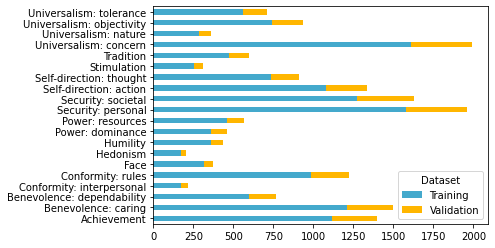

In [ ]:
# create plot and save
colors = ['#44A9CC', '#FFB600']

label_distn_tab.plot(kind='barh', stacked=True, color=colors)
plt.ylabel(None)
plt.savefig('/content/drive/MyDrive/csci5832_project/figs/label_distn.png',
            bbox_inches = 'tight')
plt.show()